# The London Railway Network

The cell below defines the abstract class whose API you will need to impement. Do NOT modify it.

In [279]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

Use the cell below to define any data structure and auxiliary python function you may need. Leave the implementation of the main API to the next code cell instead.

In [280]:
# ADD YOUR DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE
#### Data Structures ####

from math import sqrt,cos, sin, radians, sqrt, atan2, pi
from matplotlib import pyplot as plt

def harvensineDistance(lat1, lng1, lat2, lng2):
    earthRadius = 3958.7613322984894 # earth's radius in miles
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)
    lng1 = radians(lng1)

    dLat = lat2-lat1;
    dLng = lng2-lng1;
    a = sin(dLat/2) * sin(dLat/2) + cos(lat1) * cos(lat2) * sin(dLng/2) * sin(dLng/2);
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return earthRadius * c

class PQ:
    
    """
    Min-Oriented Prioirty Queue implemented with binary heap
    """

    def __init__(self):
        self.values = []
    
    def insert(self, value):
        # inserts new value at the very end and swim up if the value is less than the value above in the heap
        self.values.append(value)
        self.__swim_up(len(self.values) - 1)

    def delMin(self):

        if len(self.values) == 0: 
            return None

        # swap the first and last element of the values
        self.__swap(0, len(self.values) - 1)
        output = self.values.pop()
        # sink the new swapped value that is at the top of the heap down
        self.__sink(0)
        return output

    def size(self):
        return len(self.values)
    
    def contains(self, targetValue):
        for value in self.values:
            if value == targetValue:
                return True
        return False

    def isEmpty(self):
        return self.size() == 0


    def __sink(self, targetIndex):
        
        queueSize = len(self.values)


        while True:
            leftIndex = 2 * targetIndex + 1
            rightIndex = 2 * targetIndex + 2

            smaller = leftIndex

            if rightIndex < queueSize and self.values[rightIndex] < self.values[smaller]:
                smaller = rightIndex
            
            # needs to be >= here because the case of just two values
            if leftIndex >= queueSize or self.values[smaller] > self.values[targetIndex]:
                break

            self.__swap(smaller, targetIndex)
            targetIndex = smaller

    def decreaseKey(self, targetValue, priority):
            """
            Decrease the priority of an existing value inside the queue
            
            This is used when the value is already inside the queue,
            instead of adding an extra item to the queue decrease the existing one instead
            """
            index = 0
            for value in self.values:
                if value == targetValue:
                    value.priority = priority
                    self.__swim_up(index)
                    # self.__sink(index)
                index += 1


    def __swim_up(self, targetIndex):
        parent_index = (targetIndex - 1) // 2

        while self.values[targetIndex] < self.values[parent_index] and targetIndex > 0:

            self.__swap(parent_index, targetIndex)

            targetIndex = parent_index
            parent_index = (targetIndex - 1) // 2


    def __swap(self, firstIndex, secondIndex):
        tmp = self.values[firstIndex]
        self.values[firstIndex] = self.values[secondIndex]
        self.values[secondIndex] = tmp



class PQItem:
    """ Wrapper Data type to facilitate storing value, where the value is not necessarily its weight
    
    ie, (any, 3) the value is anything, but the weight would be 3, useful for string vertex id and the value to go 
    to it
    
    """
    def __init__(self, name, priority):
        self.name = name
        self.priority = priority
    
    def __eq__(self, name):
        return self.name == name
    
    def __ge__(self, other):
        return self.priority >= other.priority

    def __gt__(self, other):
        return self.priority > other.priority
    
    def __le__(self, other):
        return self.priority <= other.priority
    
    def __lt__(self, other):
        return self.priority < other.priority

class Graph:
    """
    Adjacency List Graph Representation
    """
    def __init__(self, V):
        self.V = V
        self.adj = []
        for _ in range (0, V):
            self.adj.append([])

    def addEdge(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        self.adj[v].append(e)
        # self.adj[w].append(e)
        # we have to swap here because we have to relax its outgoing edges, 
        # if we don't swap the direction around it would relax the wrong end
        # i.e vertex 0 has edge 0 -> 1, but vertex 1 would also has edge 0 -> 1 if we don't swap it around
        self.adj[w].append(e.swap())

    def adjacencies(self, v):
        return self.adj[v]


class TSPGraph(Graph):
    
    """
    Adjancency List Graph Representation for Travelling Salesman Problem
    
    Added methods are for third problem to return station names and generate a complete graph
    
    It precomputes the minimum edges in ascending order using the min-pq, and also stores the 
    list of stations to be referenced later when generating the output of list of names
    """

    def __init__(self, V, stations):
        super().__init__(V)
        self.stations = []
        self.minEdges = PQ()
        self.__createCompleteGraph(stations)
    
    def getStations(self):
        return self.stations.copy()
    
    def __euclideanDistance(self, lat1, lng1, lat2, lng2):
        return sqrt((lat1-lat2) ** 2 + (lng1-lng2) ** 2)

    def __createCompleteGraph(self, inputStations):
        for index, currentStation in enumerate(inputStations):
            for createdStationIndex, createdStation in enumerate(self.stations):
                distance = self.__euclideanDistance(self.stations[createdStationIndex].lat, self.stations[createdStationIndex].lng, currentStation.lat, currentStation.lng)
                edge = Edge(index, createdStationIndex, distance)
                self.addEdge(edge)
                self.minEdges.insert(edge)
            self.stations.append(currentStation)



class Edge:
    """
    Edge Representation for the graph
    
    Overwritten the comparison methods to use the edge's weight
    for ease of comparing when added to a priority queue
    
    """
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight

    def endPoint(self):
        return self.v

    def otherEndPoint(self, vertex):
        if vertex == self.v:
            return self.w
        return self.v

    def same(self, e):
        return self.v == e.endPoint() and self.w == e.otherEndPoint(e.endPoint()) and self.weight == e.getWeight()

    def getWeight(self):
        return self.weight

    def swap(self):
        return Edge(self.w, self.v, self.weight)
    
    def __str__(self):
        return f"v: {self.v}, w: {self.w}, weight: {self.weight}"
    
    def __eq__(self, other):
        return self.weight == other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight

    def __gt__(self, other):
        return self.weight > other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __lt__(self, other):
        return self.weight < other.weight
    

    
class Queue():
    def __init__(self):
        self.queue = []
    
    def isEmpty(self):
        return self.queue == []
    
    def enqueue(self, item):
        self.queue.append(item)
    
    def dequeue(self):
        return self.queue.pop(0)
    
    def size(self):
        return len(self.queue)
    
class StationInfo:

    def __init__(self, station_id, name, lat, lng):
        self.station_id = station_id
        self.name = name
        self.lat = float(lat)
        self.lng = float(lng)
    
    def getName(self):
        return self.name

    def __str__(self):
        return f"station_id: {self.station_id}, latitude: {self.lat}, longitude: {self.lng}"
    


In [281]:
#### Algorithms ####

class BFS:
    """
    Breath-First-Search Algorithm
    """
    def __init__(self, G, s):
        self.starting = s
        self.distToSource = [-1 for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range(0, G.V)]
        self.__bfs(G, s)

    def __bfs(self, G, s):
        q = Queue()
        q.enqueue(s)
        self.distToSource[s] = 0
        while(not q.isEmpty()):
            v = q.dequeue()

            for w in G.adjacencies(v):
                index = w.otherEndPoint(v)
                if (self.distToSource[index] == -1):
                    q.enqueue(index)
                    self.distToSource[index] = self.distToSource[v] + 1
                    self.edgeTo[index] = v
    
    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    
    def pathTo(self, v):
        # Construct the path back to origin, useful for debugging to see if the output is correct
        if (not self.hasPathTo(v)): return None

        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path


    def lengthTo(self, v):
        # Get total weight from origin to v Vertex
        if (not self.hasPathTo(v)): return None

        return self.distToSource[v] 

    
class DFS:
    """
    Depth-First-Search Algorithm
    """
    path = []
    x = []
    y = []
    score = 0
    def __init__(self, G, s, names):
        self.names = names
        self.starting = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range (0, G.V)]
        self.path.append(self.names[s].getName())
        self.x.append(self.names[s].lat)
        self.y.append(self.names[s].lng)
        self.__dfs(G,s)
    
    def __dfs(self, G, v):
        self.marked[v] = True
        for w in G.adjacencies(v):
            currentPoint = w.otherEndPoint(w.endPoint())
            if (not self.marked[currentPoint]):
                self.path.append(self.names[currentPoint].getName())
                self.score += w.weight
                self.x.append(self.names[currentPoint].lat)
                self.y.append(self.names[currentPoint].lng)
                self.__dfs(G,currentPoint)
                self.edgeTo[currentPoint] = v
    
    def hasPathTo(self, v):
        return self.marked[v]

    # build the path backwards 
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path   
    

    
class LazyPrimMST:
    
    """
    Generate the minimum spanning tree using Prim's algorithm
    """
    def __init__(self, G):
        self.marked = [False for v in range(0, G.V)]
        self.mst = Queue()
        self.mstGraph = Graph(G.V)
        self.pq = PQ()
        self.__visit(G, 0)
        
        limit = G.V - 1
        while (not self.pq.isEmpty() and self.mst.size() < limit):
            e = self.pq.delMin()
            v = e.endPoint()
            w = e.otherEndPoint(v)

            if self.marked[v] and self.marked[w]:
                continue
            self.mst.enqueue(e)
            self.mstGraph.addEdge(e)

            if not self.marked[v]:
                self.__visit(G, v)
            
            if not self.marked[w]:
                self.__visit(G, w)
    
    def __visit(self, G, v):
        self.marked[v] = True

        for e in G.adjacencies(v):
            if not self.marked[e.otherEndPoint(v)]:
                self.pq.insert(e)

class Dijkstra:

    def __init__(self, G, s, withDecreaseKey = False):
        self.withDecreaseKey = withDecreaseKey
        self.edgeTo = [None for v in range (0, G.V)]
        # -1 for infinity since weight cannot be negative
        self.distTo = [-1 for v in range(0, G.V)]
        self.distTo[s] = 0


        self.pq = PQ()
        self.pq.insert(PQItem(s, 0))
        self.starting = s

        while not self.pq.isEmpty():
            v = self.pq.delMin().name
            for e in G.adjacencies(v):
                self.__relax(e)

    def __relax(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        # print(w)
        if self.distTo[w] > self.distTo[v] + e.getWeight() or self.distTo[w] == -1:
            self.distTo[w] = self.distTo[v] + e.getWeight()
            self.edgeTo[w] = e
            
            # small optimisation to not just add in a new edge
            # since Dijkstra has to loop through all the edges added to the priority queue
            # tested that dijkstra without decrease-key is actually faster in practice, than optimising the
            # amounts in the priority queue
            if self.withDecreaseKey:
                if self.pq.contains(w):
                    self.pq.decreaseKey(w, self.distTo[w])
                else:
                    self.pq.insert(PQItem(w, self.distTo[w]))
            else:
                self.pq.insert(PQItem(w, self.distTo[w]))



    # def hasPathTo(self, v):
    #     return self.distToSource[v] != -1
    

    def pathTo(self, v):
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x].endPoint()
        path.append(self.starting)
        return path

    def lengthTo(self, v):
        return self.distTo[v] 
    
#1 for christofides calculate mst
#2 get odd degree vertexes from mst, this must be even
#3 find the minimum weight maximal matching
#4 do union of the graph from 2 and 3
#5 do eulerian path of the graph from 4
class Christofides:

    def __init__(self, G):
        self.G = G
        self.__perform()
        
    def getPath(self):
        result = DFS(self.unionGraph, 0, self.G.getStations())
        return result.path, result.x, result.y, result.score
        

    def __perform(self):

        mstGraph = self.__generateMSTGraph()
        

        # get all the odd stations
        oddVerticesStation = self.__getOddVertices(mstGraph)
        
        minWeightMaximalEdges = self.__getMinWeightMatching(self.G, oddVerticesStation)
        
        self.__union(mstGraph, minWeightMaximalEdges)
        
    def __getOddVertices(self, G):
        oddVertices = []
        for v in range(self.G.V):
            if len(G.adjacencies(v)) % 2 != 0:
                oddVertices.append(v)
        return oddVertices

    def __union(self, G, minWeightMaximalEdges):
        for edge in minWeightMaximalEdges:
            G.addEdge(edge)
        
        self.unionGraph = G
        
    def __generateMSTGraph(self):
        mstGraph = LazyPrimMST(self.G).mstGraph
        
        return mstGraph
        

    def __getMinWeightMatching(self, G, oddVertices):
        """
        Get the edges for the min-weight maximal matchings, 
        it works by starting from the minimum edge that was precomputed by the TSPGraph
        and checking whether the two endpoints are part of the odd vertices from the MST,
        and has not been marked as True(taken already by another edge).
        
        """
        marked = {}
        for v in oddVertices:
            marked[v] = False
        
        # The number of maximal edges for a complete graph is the number of vertices divide by 2
        amount = len(oddVertices) // 2

        minMaximalEdges = []

        gotten = 0

        while gotten < amount:
            nextEdge = G.minEdges.delMin()
            if marked.get(nextEdge.v) == False and marked.get(nextEdge.w) == False:
                minMaximalEdges.append(nextEdge)
                marked[nextEdge.v] = True
                marked[nextEdge.w] = True
                gotten += 1
        return minMaximalEdges
    
class TwoApprox:

    def __init__(self, G):
        mst = LazyPrimMST(G)
        dfsGraph = Graph(G.V)

        for edge in mst.mst.queue:
            dfsGraph.addEdge(edge)

        result = DFS(dfsGraph, 0, G.getStations())
        self.result = result
    
    def getPath(self):
        return self.result.path, self.result.x, self.result.y, self.result.score

Use the cell below to implement the requested API.

In [282]:
import csv

class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
    stations = {}
    # auxiliary array to reverse map index to name of station
    stationNames = []
    
    def __init__(self):
        pass
        
    def loadStationsAndLines(self):
        self.__loadStations()
        self.__loadLines()
    
    def __loadStations(self):
        with open('londonstations.csv') as file:
            reader = csv.reader(file, delimiter='\n')
            first = True
            id_counter = 0
            for row in reader:
                if first:
                    first = False
                    continue
                rowContent = row[0].split(',')
                self.stations[rowContent[0]] = StationInfo(id_counter, rowContent[0], rowContent[1], rowContent[2])
                self.stationNames.append(rowContent[0])
                id_counter+=1

            self.graph = Graph(id_counter + 1)

    def __loadLines(self):
        with open('londonrailwaylines.csv') as file:
            reader = csv.reader(file, delimiter='\n')
            first = True

            for row in reader:
                if first:
                    first = False
                    continue
                rowContent = row[0].split(',')
                fromStation = self.stations[rowContent[1]]
                toStation = self.stations[rowContent[2]]
                
                distanceBetweenStation = harvensineDistance(fromStation.lat,fromStation.lng, toStation.lat, toStation.lng)
                
                self.graph.addEdge(Edge(fromStation.station_id, toStation.station_id, distanceBetweenStation))

    # method for debugging
    def __convertToStationName(self, station_ids):
        output = []
        for station_id in station_ids:
#             print(station_id)
            output += [self.stationNames[station_id]]
        return output       
                
                
    
    def minStops(self, fromS, toS):     
        numStops = -1
        result = BFS(self.graph, self.stations[fromS].station_id)
        numStops = result.lengthTo(self.stations[toS].station_id)
        stationsId = result.pathTo(self.stations[toS].station_id)
        print(self.__convertToStationName(stationsId))

        return numStops 
    
    def minDistance(self, fromS, toS):
        result = Dijkstra(self.graph, self.stations[fromS].station_id, False)
        minDistance = result.lengthTo(self.stations[toS].station_id)

        return minDistance
    
    def __useTwoApprox(self, graph):
        result = TwoApprox(graph)
        return result.getPath()
    
    def __useChristofides(self, graph):
        result =  Christofides(graph).getPath()
        return result
    
    def newRailwayLine(self, inputList):
        stations = []
        for stationName in inputList:
            stations.append(self.stations[stationName])

        newGraph = TSPGraph(len(inputList), stations)
        path, x, y, score = self.__useTwoApprox(newGraph)
        print(score)
#         print(path)

        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        ax.plot(x,y, 'o-')
        plt.show()
        return path

0.8675320322927752


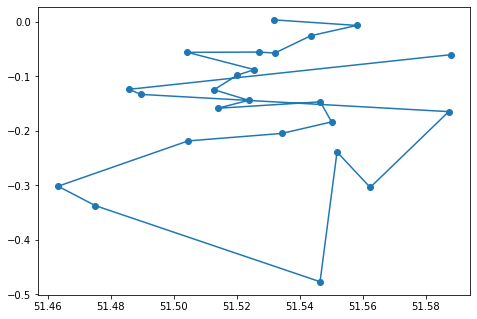

0.11228262500026176


In [283]:
import timeit

test = LondonRailwayMapper()
test.loadStationsAndLines()

arguments = ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping', "Stamford Hill", "Acton Town", "Battersea Park"]
arguments = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]
arguments = ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping']


t = timeit.Timer(lambda: test.newRailwayLine(arguments))
time = t.timeit(1) / 1
print(time)

Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.

In [169]:
import timeit
import random
# Min stops testing

def displayResults(results):
    for key, value in results.items():
        print("Vertex Amount: {0}, Time taken(s): {1}".format(key, value))

# Random graph generator
def generateRandomGraph(vertexAmount, config):
    G = Graph(vertexAmount)
    
    for v in range(vertexAmount):
        # by default we connect all the stations together
        
        if v + 1 < vertexAmount:
            G.addEdge(Edge(v, v + 1, random.randint(1, 200)))
        
        if (v + 1) % config["frequency_of_branching"] == 0:
            
            upper = 0
            
            if config.get("branching_rate") != None:
                
                upper = vertexAmount // config["branching_rate"]
            else:
                
                upper = config["max_branching_station"]
            randomAmountOfEdges = random.randint(config["min_branching_station"], upper)
            
            for _ in range(randomAmountOfEdges):
                
                randomToVertex = random.randint(0, vertexAmount - 1)
                G.addEdge(Edge(v, randomToVertex, random.randint(1, 200)))
                
    return G

def generateRandomGraphs(vertexAmount, config, amount = 5):
    graphs = []
    
    for _ in range(amount):
        
        graphs.append(generateRandomGraph(vertexAmount, config))

    return graphs

def testMinStops(amounts, config):
    result = {}
    
    for amount in amounts:
        
        testGraphs = generateRandomGraphs(amount, config)
        result[amount] = performMinstopsTest(testGraphs)
        
    return result

def performMinstopsTest(graphs):    
    result = 0
    
    for graph in graphs:
        
        t = timeit.Timer(lambda: BFS(graph, 0).lengthTo(99))
        result += t.timeit(1)
    
    return result / 5



config = {
     # Stations till you generate random connections with more than 1 stations, ie every 8 stations
    "frequency_of_branching": 8,
    # Minimum edges to add
    "min_branching_station": 2,
    
    # Upper bound for amount of branching stations as proportion to vertex amount, for example its 100 // 8
    # = 12, the generator will randint between(2, 12)
    "branching_rate": 8
}

verticesToTest = [100, 200, 300, 400, 500,600,700,800,900, 1000]

result = testMinStops(verticesToTest, config)
print("minStops API Test")
print("average time for 5 runs for each vertexAmount")
displayResults(result)

minStops API Test
average time for 5 runs for each vertexAmount
Vertex Amount: 100, Time taken(s): 0.00023458300001948372
Vertex Amount: 200, Time taken(s): 0.0005313623999427363
Vertex Amount: 300, Time taken(s): 0.0010532200000852754
Vertex Amount: 400, Time taken(s): 0.0014663877999737452
Vertex Amount: 500, Time taken(s): 0.0016478800001095805
Vertex Amount: 600, Time taken(s): 0.0024552330000005896
Vertex Amount: 700, Time taken(s): 0.003204214800007321
Vertex Amount: 800, Time taken(s): 0.003942335400006413
Vertex Amount: 900, Time taken(s): 0.005080690399972809
Vertex Amount: 1000, Time taken(s): 0.006139962599900173


In [170]:
# Min Distance Testing

config = {
    "frequency_of_branching": 8,
    "min_branching_station": 2,
    "branching_rate": 3 # dense graph so branching rate is low here
}

def testMinDistance(amounts, config):
    result = {}
    for amount in amounts:
        testGraphs = generateRandomGraphs(amount, config)
        result[amount] = performMinDistanceTest(testGraphs)
    return result

def performMinDistanceTest(graphs):    
    result = 0
    
    for graph in graphs:
        toPoint = random.randrange(1, graph.V)
        withoutDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, False).lengthTo(toPoint))
        result += withoutDecreaseKey.timeit(1)
    return result / 5


testConfigs = {
    "Result for dense graph": {
        "frequency_of_branching": 8,
        "min_branching_station": 2,
        "branching_rate": 3
    },
    "Result for average graph":{
        "frequency_of_branching": 4,
        "min_branching_station": 2,
        "max_branching_station": 8
    },
    "Result for sparse graph": {
        "frequency_of_branching": 14,
        "min_branching_station": 2,
        "max_branching_station": 6
    }
}

def performMultipleConfigTests(verticesToTest, configs):
    for key, currentConfig in configs.items():
        print(key)
        result = testMinDistance(verticesToTest, currentConfig)
        displayResults(result)
        print("\n")

performMultipleConfigTests(verticesToTest, testConfigs)

Result for dense graph
Vertex Amount: 100, Time taken(s): 0.0021141478000572533
Vertex Amount: 200, Time taken(s): 0.007085325800107967
Vertex Amount: 300, Time taken(s): 0.014181937600096717
Vertex Amount: 400, Time taken(s): 0.02259973980007999
Vertex Amount: 500, Time taken(s): 0.034347456800151124
Vertex Amount: 600, Time taken(s): 0.045755714999995686
Vertex Amount: 700, Time taken(s): 0.06254396879994602
Vertex Amount: 800, Time taken(s): 0.08786481939987426
Vertex Amount: 900, Time taken(s): 0.10340697980000187
Vertex Amount: 1000, Time taken(s): 0.1504839973998969


Result for average graph
Vertex Amount: 100, Time taken(s): 0.0014361983999151562
Vertex Amount: 200, Time taken(s): 0.0029742214000179957
Vertex Amount: 300, Time taken(s): 0.0044095094001022515
Vertex Amount: 400, Time taken(s): 0.006881021600020176
Vertex Amount: 500, Time taken(s): 0.007603587800076639
Vertex Amount: 600, Time taken(s): 0.010845482200056721
Vertex Amount: 700, Time taken(s): 0.011339531799967517

In [171]:
# new railway line testing








The cell below exemplifies the test code I will invoke on your submission. Do NOT modify it. 


Execution time to load: 0.006
['North Wembley', 'Wembley Central', 'Euston', 'Warren Street', 'Oxford Circus', 'Regents Park', 'Baker Street']

Execution time minStops: 0.001
Execution time minDistance: 0.006
From Baker Street to North Wembley in 6 stops and 8.227662241834029 miles
['Belsize Park', 'Chalk Farm', 'Camden Town', 'Euston', 'Kings Cross St. Pancras', 'Farringdon', 'Liverpool Street', 'Stratford', 'Leyton', 'Leytonstone', 'Snaresbrook', 'South Woodford', 'Woodford', 'Buckhurst Hill', 'Loughton', 'Debden', 'Theydon Bois', 'Epping']

Execution time minStops: 0.001
Execution time minDistance: 0.006
From Epping to Belsize Park in 17 stops and 20.64961370677551 miles
['Balham', 'Streatham Hill', 'Tulse Hill', 'East Croydon', 'London Bridge', 'Bank', 'Moorgate', 'Old Street', 'Essex Road', 'Highbury and Islington', 'Canonbury']

Execution time minStops: 0.001
Execution time minDistance: 0.006
From Canonbury to Balham in 10 stops and 8.840184381413101 miles
['Leytonstone', 'Leyto

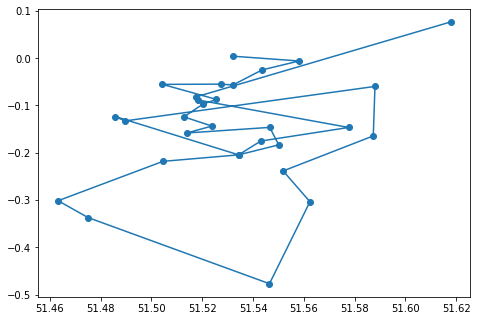



Station list ['Queens Park', 'Chigwell', 'Moorgate', 'Swiss Cottage', 'Liverpool Street', 'Highgate']
New station line ['Abbey Road', 'Leyton', 'Hackney Wick', 'Cambridge Heath', 'Bethnal Green', 'Wapping', 'Old Street', 'Barbican', 'Covent Garden', 'Great Portland Street', 'Marble Arch', 'Kentish Town West', 'Finchley Road and Frognal', 'Queens Park', 'Shepherds Bush', 'Richmond', 'Isleworth', 'Uxbridge', 'North Wembley', 'Dollis Hill', 'East Finchley', 'Tottenham Hale', 'Pimlico', 'Vauxhall', 'Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell']
Total track length from Abbey Road to Chigwell : 9.879072967178624 miles
Execution time newLine: 0.11


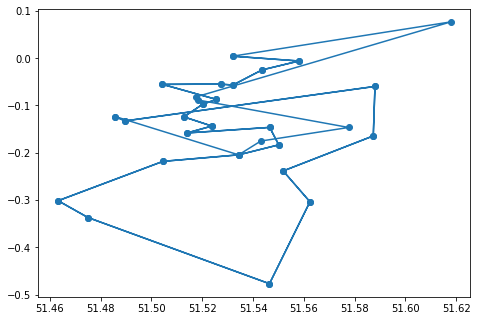



Station list ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping']
New station line ['Abbey Road', 'Leyton', 'Hackney Wick', 'Cambridge Heath', 'Bethnal Green', 'Wapping', 'Old Street', 'Barbican', 'Covent Garden', 'Great Portland Street', 'Marble Arch', 'Kentish Town West', 'Finchley Road and Frognal', 'Queens Park', 'Shepherds Bush', 'Richmond', 'Isleworth', 'Uxbridge', 'North Wembley', 'Dollis Hill', 'East Finchley', 'Tottenham Hale', 'Pimlico', 'Vauxhall', 'Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell', 'Abbey Road', 'Leyton', 'Hackney Wick', 'Cambridge Heath', 'Bethnal Green', 'Wapping', 'Old Street', 'Barbican', 'Cove

In [172]:
# DO NOT MODIFY THIS CELL

import timeit

testMapper = LondonRailwayMapper()

#
# testing the loadStationsAndLines() API 
#
starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

#
# testing the minStops() and minStops() API on a sample of from/to station pairs  
#
fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minDistance(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    
#
# testing the newRailwayLine() API on a small list of stations  
#
stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

#
# testing the newRailwayLine() API on a big list of stations  
#
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

In [173]:
# Generating a graph where there's only one edge per vertex, essentially simulating a train line
# Since most of the stations does not branch to more than 1 station
test = LondonRailwayMapper()
def generateSparseGraph(verticesAmount):
    graphs = []
    for _ in range(0, 5):
        G = Graph(verticesAmount)

        for i in range(verticesAmount):
            if i + 1 < verticesAmount:
                G.addEdge(Edge(i, i + 1, random.randint(1, 200)))
        graphs.append(G)
    
    return graphs


testVerticesAmount = [500, 1000, 2000, 5000, 10000, 15000]
def testSparse(amounts):
    result = {}
    for amount in amounts:
        testGraphs = generateSparseGraph(amount)
        result[amount] = performTests(testGraphs)
    return result

def performTests(graphs):    
    result = {"withDecrease": 0, "withoutDecrease": 0}
    
    for graph in graphs:
        toPoint = random.randrange(1, graph.V)
        withoutDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, False).lengthTo(toPoint))
        withDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, True).lengthTo(toPoint))
        
        result["withDecrease"]  += withDecreaseKey.timeit(1)
        result["withoutDecrease"] += withoutDecreaseKey.timeit(1)
    
    result["withDecrease"] = result["withDecrease"] / 5
    result["withoutDecrease"] = result["withoutDecrease"] / 5
    
    return result
    

testSparse(testVerticesAmount)

{500: {'withDecrease': 0.002659813800073607,
  'withoutDecrease': 0.002420076199905452},
 1000: {'withDecrease': 0.004430588600098417,
  'withoutDecrease': 0.0042993081999156855},
 2000: {'withDecrease': 0.008131938400038053,
  'withoutDecrease': 0.007918502200027433},
 5000: {'withDecrease': 0.020333783400110404,
  'withoutDecrease': 0.018063061399971048},
 10000: {'withDecrease': 0.03988052939994304,
  'withoutDecrease': 0.03739587059990299},
 15000: {'withDecrease': 0.060611541800062695,
  'withoutDecrease': 0.0574180446000355}}

In [174]:
import random


# this simulates how many stations till you reach a station that can transfer to another line
frequency_of_branching = 8
min_branching_station = 2
max_branching_station = 8

def generateRandomGraph(vertexAmount):
    G = Graph(vertexAmount)
    
    for v in range(vertexAmount):
        # by default there needs to be one edge that connects it
        if v + 1 < vertexAmount:
            G.addEdge(Edge(v, v + 1, random.randint(1, 200)))
        
        if (v + 1) % frequency_of_branching == 0:
            randomAmountOfEdges = random.randint(min_branching_station, max_branching_station)
            for _ in range(randomAmountOfEdges):
                randomToVertex = random.randint(0, vertexAmount - 1)
                G.addEdge(Edge(v, randomToVertex, random.randint(1, 200)))
    return G

def generateRandomGraphs(vertexAmount):
    graphs = []
    for _ in range(0, 5):
        graphs.append(generateRandomGraph(vertexAmount))
    return graphs

testVerticesAmount = [500, 1000]
def testAverage(amounts):
    result = {}
    for amount in amounts:
        testGraphs = generateRandomGraphs(amount)
        result[amount] = performTests(testGraphs)
    return result

def performTests(graphs):    
    result = {"withDecrease": 0, "withoutDecrease": 0}
    
    for graph in graphs:
        toPoint = random.randrange(1, graph.V)
        withoutDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, False).lengthTo(toPoint))
        withDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, True).lengthTo(toPoint))
        
        result["withDecrease"]  += withDecreaseKey.timeit(1)
        result["withoutDecrease"] += withoutDecreaseKey.timeit(1)
    
    result["withDecrease"] = result["withDecrease"] / 5
    result["withoutDecrease"] = result["withoutDecrease"] / 5
    
    return result
    

results = testAverage(testVerticesAmount)

500
0.005880559799970797
0.014139755999985936



1000
0.012795381399882899
0.04473480819997348





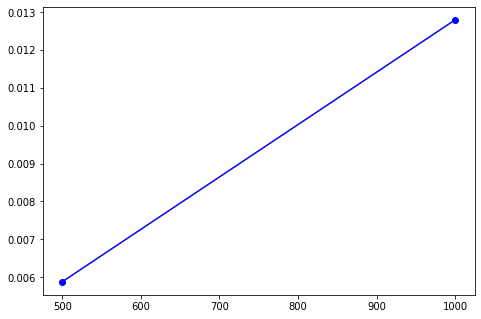

In [175]:
from matplotlib import pyplot as plt


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = []
y = []
withDecrease = []
for key in results.keys():
    x.append(key)
    y.append(results[key]["withoutDecrease"])
    print(key)
    print(results[key]["withoutDecrease"])
    print(results[key]["withDecrease"])
    withDecrease.append(results[key]["withDecrease"])
    print("\n\n")
    
ax.plot(x, y, 'bo-', color='blue')

# ax.plot(x, withDecrease, 'ro-', color='red')
plt.show()